<a href="https://colab.research.google.com/github/Indian-otaku/Introduction_To_PyTorch/blob/main/cnn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary modules

In [40]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
from timeit import default_timer
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import random

In [41]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
!pip install -U mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import torchmetrics
import mlxtend

In [44]:
print("Torch: ",torch.__version__)
print("Torchvision: ",torchvision.__version__)
print("Torchmetrics: ",torchmetrics.__version__)
print("Mlxtend: ",mlxtend.__version__)

Torch:  1.13.1+cu116
Torchvision:  0.14.1+cu116
Torchmetrics:  0.11.3
Mlxtend:  0.21.0


## Device agnostic code

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting the data and transforming it into DataLoaders

In [46]:
train_data = MNIST(root="data",
                   train=True,
                   transform=ToTensor(),
                   target_transform=None,
                   download=True)
test_data = MNIST(root="data",
                  train=False,
                  transform=ToTensor(),
                  target_transform=None,
                  download=True)

In [47]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [48]:
BATCH_SIZE = 32
torch.manual_seed(100)
torch.cuda.manual_seed(100)

train_data_loader = DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               drop_last=False)
test_data_loader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=False)

In [49]:
train_data_loader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

## Visualize the data

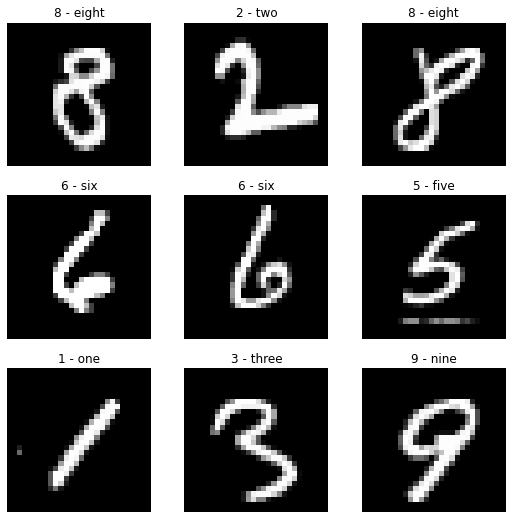

In [50]:
plt.figure(figsize=(9,9))
for i, (image, label) in enumerate(random.sample(list(train_data_loader.dataset), k=9)):
    plt.subplot(3, 3, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(train_data_loader.dataset.classes[label])
    plt.axis(False)
plt.show()

## Creating the model

In [51]:
class MNISTModel1(nn.Module):
    def __init__(self, n_input_channels, n_neurons_per_hidden_layer, n_output_classes):
        super().__init__()
        self.convbatch1 = nn.Sequential(
            nn.Conv2d(in_channels=n_input_channels,
                      out_channels=n_neurons_per_hidden_layer,
                      kernel_size=3,
                      stride=1,
                      padding=0,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_neurons_per_hidden_layer,
                      out_channels=n_neurons_per_hidden_layer,
                      kernel_size=3,
                      stride=1,
                      padding=0,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=1,
                         padding=0)
        )
        self.nnlayer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=n_neurons_per_hidden_layer*23*23, 
                      out_features=n_neurons_per_hidden_layer,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.Linear(in_features=n_neurons_per_hidden_layer,
                      out_features=n_output_classes,
                      bias=True,
                      device=device,
                      dtype=torch.float)
        )
    
    def forward(self, x: torch.Tensor)-> torch.Tensor:
        return self.nnlayer1(self.convbatch1(x))


In [52]:
model1 = MNISTModel1(n_input_channels=1,
                     n_neurons_per_hidden_layer=10,
                     n_output_classes=10).to(device)
model1

MNISTModel1(
  (convbatch1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (nnlayer1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5290, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [53]:
model1(image.unsqueeze(0).to(device))

tensor([[-0.1805,  0.2598,  0.2230,  0.1170,  0.0821, -0.2799,  0.1662,  0.1617,
         -0.2958, -0.1800]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Creating accuracy function, loss function and optimizer

In [54]:
accuracy_fn = torchmetrics.Accuracy(task="multiclass",
                                    num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7]}]}

## Train and test loop

In [55]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    model.to(device)
    model.train()
    total_loss = 0
    total_acc = 0

    for index, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        label_pred_logits = model(images)
        label_prediction = torch.softmax(label_pred_logits, dim=0).argmax(dim=1)
        loss = loss_fn(label_pred_logits, labels)
        total_loss += loss
        acc = accuracy_fn(label_prediction, labels)
        total_acc += acc

        model.zero_grad()
        loss.backward()
        optimizer.step()
    
    total_loss /= len(data_loader)
    total_acc /= len(data_loader)

    print(f"Train loss: {total_loss: .5f} accuracy: {total_acc*100: .3f}")

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn,
              accuracy_fn,
              device: torch.device):
    model.to(device)
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.inference_mode():
        for index, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device)

            label_pred_logits = model(images)
            labels_prediction = torch.argmax(label_pred_logits, dim=1)
            loss = loss_fn(label_pred_logits, labels)
            total_loss += loss
            acc = accuracy_fn(labels_prediction, labels)
            total_acc += acc

        total_loss /= len(data_loader)
        total_acc /= len(data_loader)

    print(f"Test loss: {total_loss: .5f} accuracy: {total_acc*100: .3f}")


In [56]:
torch.cuda.manual_seed(42)

start_time = default_timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"--------------------------------------------------{epoch}--------------------------------------------------------")
    train_step(model=model1,
                  data_loader=train_data_loader,
                  loss_fn=loss_fn,
                  accuracy_fn=accuracy_fn,
                  optimizer=optimizer,
                  device=device)
    test_step(model=model1,
                 data_loader=test_data_loader,
                 loss_fn=loss_fn,
                 accuracy_fn=accuracy_fn,
                 device=device)

end_time = default_timer()

total_train_time = end_time - start_time
print(f"Total train time taken is {total_train_time} using device {device}")

  0%|          | 0/3 [00:00<?, ?it/s]

--------------------------------------------------0--------------------------------------------------------
Train loss:  0.41303 accuracy:  76.927
Test loss:  0.09661 accuracy:  97.214
--------------------------------------------------1--------------------------------------------------------
Train loss:  0.08141 accuracy:  88.110
Test loss:  0.06716 accuracy:  97.883
--------------------------------------------------2--------------------------------------------------------
Train loss:  0.05806 accuracy:  89.433
Test loss:  0.05856 accuracy:  98.193
Total train time taken is 61.44892628699995 using device cuda


In [57]:
# Just an audio alarm that informs if colab finished executing. 
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/5/5c/Alarm_clock_-_01.ogg").play()')

## Visualize the results of trained model

In [58]:
def plot_images_with_labels(model, data_loader, imagelist, labellist):
    plt.figure(figsize=(9,9))
    pred_probs_list = []
    pred_and_actual_list = []
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(imagelist[i].squeeze(), cmap='gray')
        pred_label_logits = model(imagelist[i].unsqueeze(0))
        pred_label_probs = torch.softmax(pred_label_logits, dim=1)
        pred_label = data_loader.dataset.classes[torch.argmax(pred_label_logits, dim=1)]
        actual_label = data_loader.dataset.classes[labellist[i]]
        title = f"Pred:{pred_label} | Truth:{actual_label}"
        pred_probs_list.append({"Prob of "+test_data_loader.dataset.classes[j]:pred_label_probs[0][j].item() for j in range(9)})
        pred_and_actual_list.append({"Pred":pred_label, "Truth":actual_label})
        if (pred_label == actual_label):
            plt.title(title, c='g')
        else:
            plt.title(title, c='r')
        plt.axis(False)
    plt.show()
    return pred_probs_list, pred_and_actual_list
       

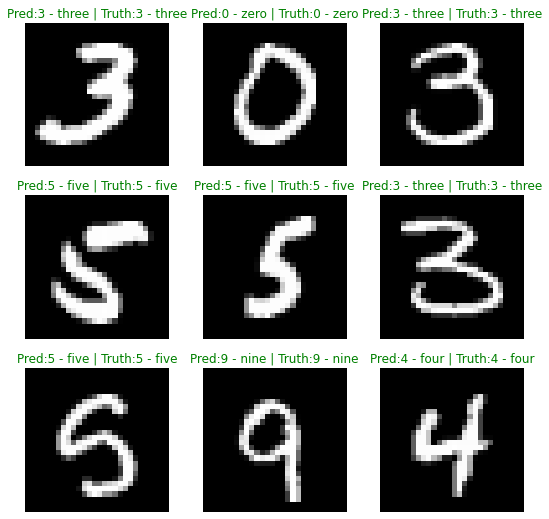

In [59]:
imagelist = []
labellist = []

for image, label in random.sample(list(test_data_loader.dataset), k=9):
    imagelist.append(image)
    labellist.append(label)

pred_probs_list, pred_and_actual_list = plot_images_with_labels(model=model1.to("cpu"),
                        data_loader=train_data_loader,
                        imagelist=imagelist,
                        labellist=labellist)

In [60]:
df1 = pd.DataFrame(pred_probs_list, dtype=str)
df2 = pd.DataFrame(pred_and_actual_list, dtype=str)
df = pd.concat([df1, df2], axis=1)
df

,Prob of 0 - zero,Prob of 1 - one,Prob of 2 - two,Prob of 3 - three,Prob of 4 - four,Prob of 5 - five,Prob of 6 - six,Prob of 7 - seven,Prob of 8 - eight,Pred,Truth
0,6.973910923573079e-14,4.336083065936691e-07,6.033745876266039e-07,0.9999988079071045,6.22781557227392e-12,1.1972336455556842e-09,7.812248929393048e-16,3.2316201270532474e-08,1.4648782098447555e-07,3 - three,3 - three
1,0.9999873638153076,2.0198018604866697e-12,2.354691019945676e-08,1.0685858420345085e-08,1.9049480959668075e-13,1.0252067568217171e-06,4.310125518713903e-07,8.130748296863999e-10,6.200049824656162e-07,0 - zero,0 - zero
2,1.66437592874491e-11,1.4982541596264554e-10,6.740820026607253e-07,0.99994957447052,5.466014781706327e-16,1.6760460539444466e-06,1.89939684531841e-14,8.826032127373651e-10,4.7967714635888115e-05,3 - three,3 - three
3,2.734293260558962e-12,3.81193862553867e-14,2.5576041257730983e-14,2.7925980248255655e-06,8.642761888674582e-18,0.9999778270721436,1.0272879213957253e-09,3.128237686250701e-14,1.9445500583969988e-05,5 - five,5 - five
4,7.0443526567487424e-09,2.364711235713912e-06,8.202010626234824e-09,0.022777849808335304,5.4145012917672375e-09,0.9767962694168091,2.586662958492525e-05,1.8175870530878768e-11,0.00018263579113408923,5 - five,5 - five
5,2.458330034763728e-13,3.421442462681057e-09,3.483315822450095e-07,0.9999871253967285,2.330128514996862e-14,3.2724253173910256e-07,2.5775942727348893e-14,2.0494322905406648e-10,1.2119711755076423e-05,3 - three,3 - three
6,2.0585953279805835e-06,7.372866965386915e-13,1.6636307609285694e-10,1.4731681119428686e-07,7.154682402088497e-11,0.9989373087882996,3.83305705327075e-05,1.0942613135056511e-11,0.0005789849674329162,5 - five,5 - five
7,4.9309200278457865e-08,4.707423253286214e-12,1.0825350393872668e-08,3.416845117953926e-08,0.00010372760880272835,8.523064138898917e-07,2.10378971188252e-11,6.8312569965200964e-06,8.52332050271798e-06,9 - nine,9 - nine
8,1.0822404170746092e-12,9.564182779087105e-11,8.695922454338145e-11,1.919437644850447e-14,0.9999970197677612,2.317841231447293e-11,6.521335554898755e-11,6.385910467088252e-08,7.335282816711697e-07,4 - four,4 - four


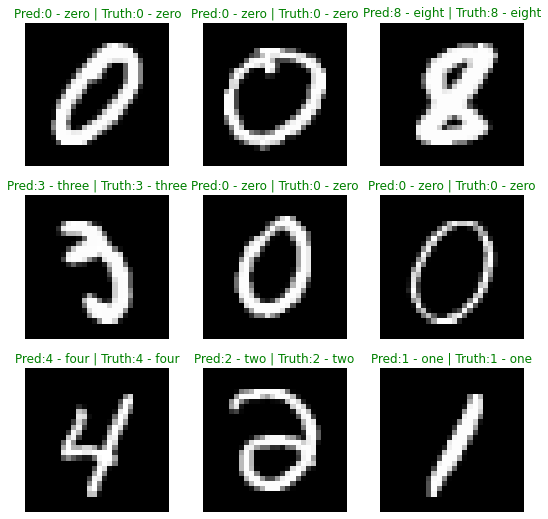

,Actual,Prediction,Pred confidence
0,0 - zero,0 - zero,99.925560
1,0 - zero,0 - zero,99.999297
2,8 - eight,8 - eight,99.143606
3,3 - three,3 - three,46.658725
4,0 - zero,0 - zero,99.998879
5,0 - zero,0 - zero,99.996698
6,4 - four,4 - four,99.999726
7,2 - two,2 - two,99.683726
8,1 - one,1 - one,99.531144


In [61]:
def plot_images_with_labels(model, data_loader, imagelist, labellist):
    plt.figure(figsize=(9,9))
    result_list = []
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(imagelist[i].squeeze(), cmap='gray')
        pred_label_logits = model(imagelist[i].unsqueeze(0))
        pred_label_probs = torch.softmax(pred_label_logits, dim=1)
        pred_label = data_loader.dataset.classes[torch.argmax(pred_label_logits, dim=1)]
        actual_label = data_loader.dataset.classes[labellist[i]]
        title = f"Pred:{pred_label} | Truth:{actual_label}"
        result_list.append({"Actual": actual_label, "Prediction":pred_label, "Pred confidence":torch.max(pred_label_probs).item()*100})
        if (pred_label == actual_label):
            plt.title(title, c='g')
        else:
            plt.title(title, c='r')
        plt.axis(False)
    plt.show()
    return result_list
imagelist = []
labellist = []

for image, label in random.sample(list(test_data_loader.dataset), k=9):
    imagelist.append(image)
    labellist.append(label)

result_list = plot_images_with_labels(model=model1.to("cpu"),
                        data_loader=train_data_loader,
                        imagelist=imagelist,
                        labellist=labellist)

pd.DataFrame(result_list)

## Saving and loading the model

In [64]:
MODEL_PATH = Path("data")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
MODEL_NAME = "MNISTModel1.pth"
FULL_PATH = MODEL_PATH / MODEL_NAME
print("Model saved at path: ", FULL_PATH)
torch.save(obj=model1.state_dict(),
           f=FULL_PATH)

Model saved at path:  data/MNISTModel1.pth


In [66]:
model2 = MNISTModel1(n_input_channels=1,
                     n_neurons_per_hidden_layer=10,
                     n_output_classes=10)
model2.load_state_dict(state_dict=torch.load(f=FULL_PATH))
model2.state_dict()

OrderedDict([('convbatch1.0.weight', tensor([[[[-0.3779, -0.4957,  0.2443],
                        [-0.3667, -0.4462,  0.4842],
                        [-0.2033, -0.5770, -0.2876]]],
              
              
                      [[[-0.0925, -0.1952, -0.2495],
                        [-0.3390, -0.2857, -0.2172],
                        [-0.0263, -0.2613,  0.5373]]],
              
              
                      [[[-0.2263,  0.4395,  0.6284],
                        [-0.6832,  0.3940,  0.2989],
                        [-0.1719, -0.1026, -0.3162]]],
              
              
                      [[[ 0.3288,  0.0562, -0.5756],
                        [-0.1085, -0.3960, -0.1871],
                        [ 0.1406, -0.1908, -0.4594]]],
              
              
                      [[[-0.1956, -0.1464, -0.2248],
                        [ 0.0269,  0.0931,  0.0614],
                        [-0.1717,  0.0865, -0.0632]]],
              
              
                      

In [68]:
test_step(model=model2,
                 data_loader=test_data_loader,
                 loss_fn=loss_fn,
                 accuracy_fn=accuracy_fn,
                 device=device)

Test loss:  0.05857 accuracy:  98.193
